## 1.- Data preparation:

### Aux function to grow nan areas in space for DataArrays

In [1]:
from scipy import signal

def buffer_nans(da, kn):
    k = np.zeros((kn,kn))
    k[kn//2,kn//2] = 1

    arr = da.values
    mask = np.ones(arr.shape).astype(np.float32)

    for i in range(arr.shape[0]):
        mask[i,:,:] = signal.convolve2d(arr[i,:,:], k, boundary='fill', mode='same')

    return da.where(~np.isnan(mask))

### Import libraries and load dataset

In [29]:
%matplotlib inline

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

ds = xr.open_dataset("Murrumbidgee_near_Bundure__MUR_B3.nc")

ds = ds.isel(x=slice(400,800), y=slice(0,400))

### Compute masking using the blue band

In [ ]:
blue = ds.nbart_blue.astype(np.float32) / 1e4

# 1.- Filter reflectances greater than 0.5 
blue = blue.where(blue<.5)

# 2.- Filter reflectances with difference to lower quartile larger than 0.05 => (0.07)
blue = blue.where((blue - blue.quantile(0.25, dim='time'))<.07)

# 3.- Grow a 5x5 buffer around NaN pixels 
blue = buffer_nans(blue, 5)

# 4.- Discard frames with more than 25% missing pixels
blue = blue.isel(time=(blue.count(dim=('x','y'))/(400*400))>.25)

blue.isel(time=3).plot()

### Apply mask to all the other bands and save for PCA training

In [ ]:
for band_name in ds:
    band = ds[band_name].astype(np.float32) / 1e4
    
    # 1. Apply blue mask
    band = band.sel(time=blue.time).where(~np.isnan(blue))

    # 2.- Interpolate NaNs over time linearly
    band = band.interpolate_na(dim='time')

    # 3.- Interpolate NaNs at the start and end using nearest neighbor
    band = band.interpolate_na(dim='time', method='nearest', fill_value='extrapolate')

    # 4.- Apply median rolling filter along time (window=3)
    band = band.rolling(time=3, min_periods=1).median()
    
    np.save(band_name, band)

## PCA decomposition

### Load libraries and create data stack

In [3]:
from sklearn.decomposition import PCA

stack = np.empty((0,400,400))

for fname in ["nbart_red.npy","nbart_green.npy","nbart_blue.npy",
              "nbart_nir_1.npy","nbart_nir_2.npy","nbart_swir_2.npy",
              "nbart_swir_3.npy"]:
    
    band = np.load(fname)
    stack = np.append(stack, band, axis=0)
    
stack = stack.reshape(stack.shape[0], -1)
    
stack.shape

(735, 400, 400)

### Compute PCA and plot explained variance with the number of components

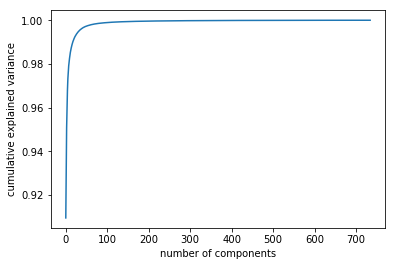

In [30]:
pca = PCA().fit(stack)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### Decompose original data using 20 PCs

In [31]:
pca = PCA(n_components=20).fit(stack)
stackT = pca.transform(stack)

stackT.shape

(735, 20)

### Regenerate initial data using the decomposed components

In [32]:
rec_stack = pca.inverse_transform(stackT)

rec_stack.shape

(735, 160000)

### Write video comparing RGB time series of the original data (left) and recreated PCA (right)

In [37]:
import imageio

writer = imageio.get_writer('video.mp4', fps=2)

for t in range(105):
    orig_r = stack[0*105+t].reshape((400,400))
    rec_r = rec_stack[0*105+t].reshape((400,400))
    orig_g = stack[1*105+t].reshape((400,400))
    rec_g = rec_stack[1*105+t].reshape((400,400))
    orig_b = stack[2*105+t].reshape((400,400))
    rec_b = rec_stack[2*105+t].reshape((400,400))
    
    writer.append_data(3*np.concatenate((np.dstack((orig_r,orig_g,orig_b)),np.dstack((rec_r,rec_g,rec_b))), axis=1))

writer.close()

In [34]:
from IPython.display import Video

Video("video.mp4")

In [9]:
coefs = pca.transform(stack)
comps = pca.components_

def plot_img(band, t):     
    f, axarr = plt.subplots(1,2)
    orig = stack[band*105+t].reshape((400,400))
    rec = rec_stack[band*105+t].reshape((400,400))
    
    axarr[0].imshow(orig, vmin=0, vmax=orig.max())
    axarr[1].imshow(rec, vmin=0, vmax=orig.max())
    
    print(orig.max(), rec.max())
    
def plot_rgb(t):     
    f, axarr = plt.subplots(1,2)
    
    orig_r = stack[0*105+t].reshape((400,400))
    rec_r = rec_stack[0*105+t].reshape((400,400))
    orig_g = stack[1*105+t].reshape((400,400))
    rec_g = rec_stack[1*105+t].reshape((400,400))
    orig_b = stack[2*105+t].reshape((400,400))
    rec_b = rec_stack[2*105+t].reshape((400,400))
    
    axarr[0].imshow(np.dstack((orig_r,orig_g,orig_b))*3)
    axarr[1].imshow(np.dstack((rec_r,rec_g,rec_b))*3)